In [12]:
%matplotlib inline

import pandas
import seaborn

seaborn.set()

In [13]:
!pwd

/home/jng/devel/peakrisk/posts


In [14]:
infile = '../files/light.csv'

In [25]:
data = pandas.read_csv(infile, index_col='date', parse_dates=['date'])

In [26]:
data.describe()

,temp,pressure,altitude,sealevel_pressure
count,4506.000000,4506.000000,4506.000000,4506.000000
mean,28.635930,101673.859521,-29.025346,101674.339991
std,0.773388,61.530502,5.111840,61.537120
min,27.200000,101521.000000,-39.222284,101522.000000
25%,28.000000,101626.000000,-32.999783,101626.000000
50%,28.500000,101682.000000,-29.762615,101683.000000
75%,29.300000,101722.000000,-25.029559,101723.000000
max,30.100000,101797.000000,-16.471391,101798.000000


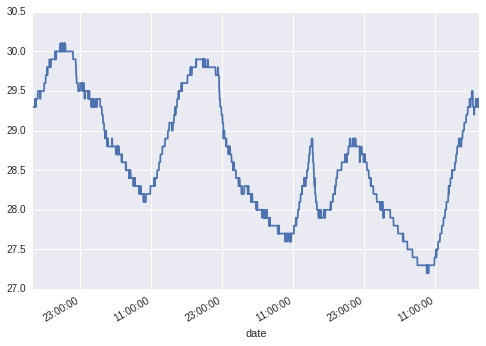

In [27]:
#data.plot()
data.temp.plot()

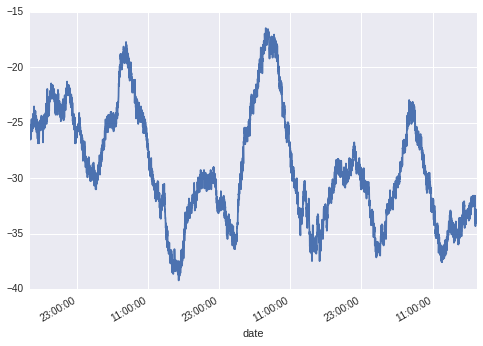

In [28]:
data.altitude.plot()

In [ ]:
data.

In [40]:
!pwd

/home/jng/devel/peakrisk/posts


In [23]:
!scp 192.168.0.133:Adafruit_Python_BMP/light.csv .
!mv light.csv ../files

light.csv                                     100%  301KB 301.4KB/s   00:00    
